# Test Download Embeddings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ee
from tqdm import tqdm
from mangroves.collection import Collection
from mangroves.geometry import Region
from mangroves.utils import haversine
from mangroves.constants import BANDS, N_BANDS

with open('/home/nus/workspace/tutorial/GEE/gee_project_key.txt', "r") as f:
    project = f.readline().strip()

collection = Collection(project=project)

2025-11-21 16:43:53,524 - INFO - Google Earth Engine initialized successfully with service account


### Inputs

In [2]:
nPixels = 128
lat0_deg = 1.41150
lon0_deg = 103.9569
year = 2018

### Reference Point

In [3]:
pt0 = ee.Geometry.Point([lon0_deg, lat0_deg], proj='EPSG:4326')
img = ee.Image(ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
               .filterDate(f'{year}-01-01', f'{year+1}-01-01')
               .filterBounds(pt0)
               .first())

### Download Image

Pixel corner distances: [np.float64(905.0966799187559), np.float64(905.0966799148846), np.float64(905.096679918791), np.float64(905.0966799171185)]


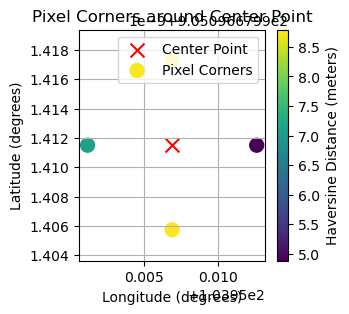

In [4]:
region = Region(lat_deg=lat0_deg, lon_deg=lon0_deg, nPixels=nPixels)

pts_distance = [
    np.sqrt(2. * haversine(lat0_deg, lat_deg, lon0_deg, lon_deg)**2) for lat_deg, lon_deg in region.pts
]

print("Pixel corner distances:", pts_distance)

plt.figure(figsize=(3, 3))
plt.scatter([lon0_deg], [lat0_deg], color='red', marker='x', s=100, label='Center Point')
plt.scatter(
    [lon for _, lon in region.pts],
    [lat for lat, _ in region.pts],
    marker='o',
    s=100,
    label='Pixel Corners',
    c=pts_distance,
    cmap='viridis',
)
plt.colorbar(label='Haversine Distance (meters)')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Pixel Corners around Center Point')
plt.axis('equal')
plt.legend()
plt.grid()

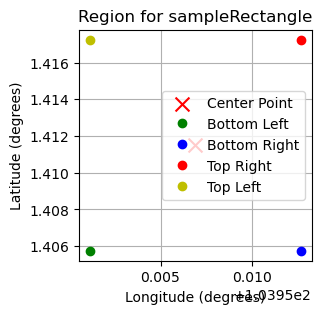

In [5]:
pixel_data = img.select(BANDS).sampleRectangle(region=region.region, properties=[], defaultValue=0)
properties = pixel_data.getInfo()['properties']

xMin, xMax, yMin, yMax = (
    region.coords['xMin'], region.coords['xMax'],
    region.coords['yMin'], region.coords['yMax']
)
plt.figure(figsize=(3, 3))
plt.scatter([lon0_deg], [lat0_deg], color='red', marker='x', s=100, label='Center Point')
plt.plot(xMin, yMin, 'go', label='Bottom Left')
plt.plot(xMax, yMin, 'bo', label='Bottom Right')
plt.plot(xMax, yMax, 'ro', label='Top Right')
plt.plot(xMin, yMax, 'yo', label='Top Left')
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
plt.title('Region for sampleRectangle')
plt.axis('equal')
plt.legend()
plt.grid()

In [6]:
region_coordinates = region.region.getInfo()['coordinates'][0]

distance_corners = [
    haversine(lat0_deg, lat, lon0_deg, lon) for lon, lat in region_coordinates
]

distance_corners

[np.float64(905.0972392400045),
 np.float64(905.0972392388874),
 np.float64(905.0961190700859),
 np.float64(905.0961190712029),
 np.float64(905.0972392400045)]

In [7]:
bands_data = {}
for i in range(N_BANDS):
    band_name = BANDS[i]
    if band_name in properties:
        band_array = np.array(properties[band_name])
        band_array = np.flipud(band_array)  # Apply flipud for correct display
        bands_data[band_name] = band_array

image_stack = []
for band_name in BANDS:
    if band_name in bands_data:
        image_stack.append(bands_data[band_name])
    else:
        # Fill missing bands with zeros
        if bands_data:
            image_shape = list(bands_data.values())[0].shape
            image_stack.append(np.zeros(image_shape))

# Stack to create D*H*W array
patch = np.stack(image_stack, axis=0)
patch.shape

(64, 128, 129)

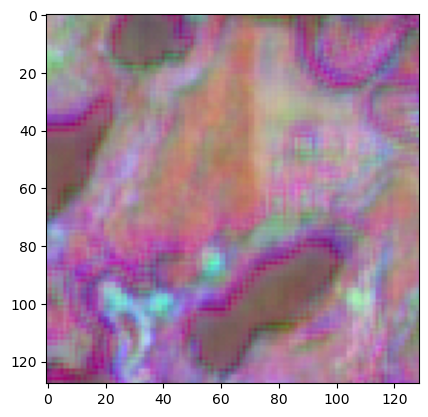

In [8]:
patch_3channels = np.transpose(patch, (1, 2, 0))[:, :, :3]
patch_3channels = (patch_3channels - patch_3channels.min()) / (patch_3channels.max() - patch_3channels.min())  # Normalize for display
plt.imshow(patch_3channels)